# Weather classification based on mean sea level pressure
Many existing weather classifications are based on mean sea level pressure fields. Mean sea level pressure is a good proxy for the dominant weather over a specific area. It can be used to estimate wind speed and direction and moreover, areas of high and low pressure bring their own characteristic weather. High pressure is associated with clear skies and calm conditions, whereas low pressure is associated with stronger winds, clouds, rain etc.

In this notebook I'll illustrate how principal component analysis can be used to extract the main features from the sea level pressure fields, and use k-means clustering to group similar flow regimes together. The data I use is from the [ERA5 reanalysis](https://software.ecmwf.int/wiki/display/CKB/ERA5+data+documentation). 

In [207]:
# Import packages

# Data & computation
import numpy as np
import xarray as xr

# For pretty map projections
from cartopy import crs as ccrs

# We'll be using two functions from the scikit-learn package
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Inspecting some example data
I'll first load some sample data (1 month) to illustrate what it looks like. The xarray package provides a very convenient interface for working with netcdf files. We'll open the file, extract the variable msl - mean sea level (pressure), and see what it looks like.

In [2]:
msl = xr.open_dataset('era5_201006_sfc.nc').msl
msl

<xarray.DataArray 'msl' (time: 720, latitude: 25, longitude: 35)>
[630000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -2.1 -1.8 -1.5 -1.2 -0.9 -0.6 -0.3 ...
  * latitude   (latitude) float32 58.2 57.9 57.6 57.3 57.0 56.7 56.4 56.1 ...
  * time       (time) datetime64[ns] 2010-06-01 2010-06-01T01:00:00 ...
Attributes:
    units:          Pa
    long_name:      Mean sea level pressure
    standard_name:  air_pressure_at_sea_level

The data comes at hourly intervals, and on a grid consisting of 25 latitudes and 35 longitudes. These are space 0.3 degrees apart. Let's sea what it looks like. I'll plot the data in two different ways: a quick and easy method that is built in to the xarray-package, and a more pretty plot using cartopy to project the data on a map. To be able to reuse this pretty plot later on, I'll wrap it in a function.

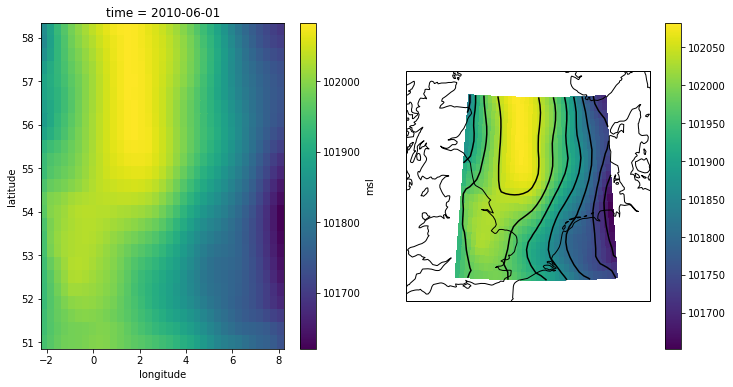

In [111]:
fig = plt.figure(figsize=(12,6))

# quick plot
ax1 = fig.add_subplot(121)
msl.isel(time=0).plot(ax=ax1)

# nice plot
def nicemap(fig=None, pos=111):
    """ Add reference map on a new axis to an existing figure """
    if not fig:
        fig = plt.figure()

    # Define the cartopy projection
    clat,clon = 52.8481667, 3.4356667
    proj = ccrs.LambertConformal(
        central_longitude=clon,
        central_latitude=clat,
        standard_parallels=(45,55),
        globe=ccrs.Globe(datum='WGS84',ellipse='sphere'))

    # Add subplot
    if type(pos)==tuple:
        ax = fig.add_subplot(*pos,projection=proj)
    else:
        ax = fig.add_subplot(pos,projection=proj)
    ax.set_extent([-5,10,50,59])
    ax.coastlines('50m')
    return ax

ax2 = nicemap(fig, 122)
mesh = ax2.pcolormesh(msl.longitude, msl.latitude, msl.isel(time=0), transform=ccrs.PlateCarree())
cont = ax2.contour(msl.longitude, msl.latitude, msl.isel(time=0), transform=ccrs.PlateCarree(), colors='k')
plt.colorbar(mesh, ax=ax2)


plt.show()

The pressure field is the main driver of the prevailing wind. On the larger scales, the wind will flow more or less parallel to the isobars (pressure contour lines above), flowing clockwise around high pressure areas and anticlockwise around low pressure areas. We can quickly show this by calculating the geostrophic wind speed. This is a rather crude estimate.

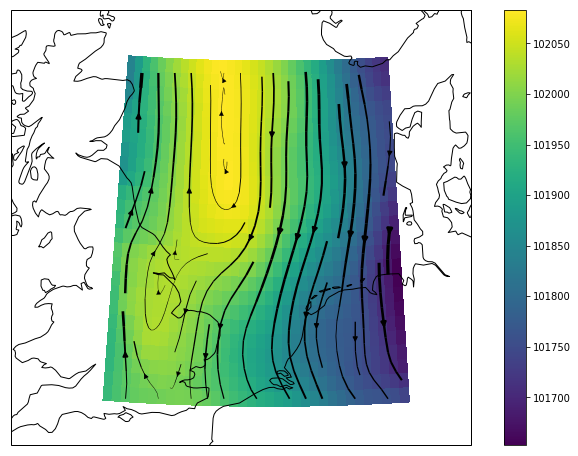

In [127]:
def geowind(mslp):
    """ Estimate geostrophic wind field based on mean sea level pressure. """
    # Note that I'm using mslp rather than msl to distinguish a single time step (2D) from the full dataset (3D)
    
    f = 1.e-4 # coriolis parameter (approximate value)
    rho = 1.23 # density (approximate value)
    r = 6371000 # radius of earth
    dx = 0.3*np.pi/180.*r*np.cos(55*np.pi/180.) # convert 0.3 degrees to meters at 55N
    dy = -0.3*np.pi/180.*r # latitude decreases along axis
    Ug = -1/(f*rho)*np.gradient(mslp.values, dy, axis=0) # np.gradient only works on numpy arrays
    Vg = 1/(f*rho)*np.gradient(mslp.values, dx, axis=1) # .values extracts the bare numpy array from xarray
    return Ug, Vg

Ug, Vg = geowind(msl.isel(time=0))

# Convert numpy array to xarray dataarray (using the dimension and coordinate info from msl)
Ug = xr.DataArray(Ug, dims=msl.isel(time=0).dims, coords=msl.isel(time=0).coords)
Vg = xr.DataArray(Vg, dims=msl.isel(time=0).dims, coords=msl.isel(time=0).coords)
speed = (Ug**2+Vg**2)**.5

fig = plt.figure(figsize=(12,8))
ax = nicemap(fig, 111)
mesh = ax.pcolormesh(msl.longitude, msl.latitude, msl.isel(time=0), transform=ccrs.PlateCarree())
lw = 5*speed / speed.max()
strp = ax.streamplot(msl.longitude, msl.latitude, Ug.values, Vg.values, # streamplot only works with numpy arrays.
                     color='k', linewidth=lw.values, transform=ccrs.PlateCarree())
plt.colorbar(mesh, ax=ax)
plt.show()

Notice how indeed, the wind follows the isobars and that it is stronger where the pressure gradient is stronger. 

## Building blocks of MSL
To illustrate how principle components can be used to represent the mean sea level pressure fields, lets consider two simplified pressure patterns. The first is a simple west-east gradient, the second south-north.

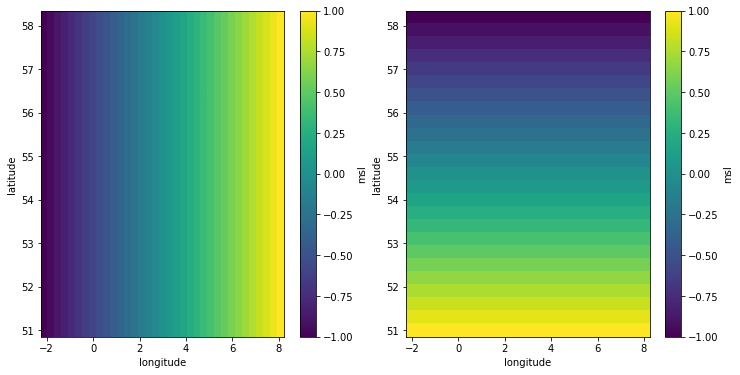

In [152]:
block1 = msl.isel(time=0).drop('time').copy() # copying the shape, dims, coordinates etc. Values will be replaced
m, n = block1.shape
block1.values = np.vstack([np.linspace(-1 , 1, n)]*m)

block2 = msl.isel(time=0).drop('time').copy()
block2.values = np.vstack([np.linspace(-1 , 1, m)]*n).T

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,6))
block1.plot(ax=ax1, cmap='viridis')
block2.plot(ax=ax2, cmap='viridis')

plt.show()

As we have seen above, the wind will flow parallel to the isobars, which means that the first building block will have a uniform wind towards the North, and the second building block will have a uniform wind towards to east. 

Now, let's see how we can combine these two building blocks to obtain a much larger palette of pressure distributions.

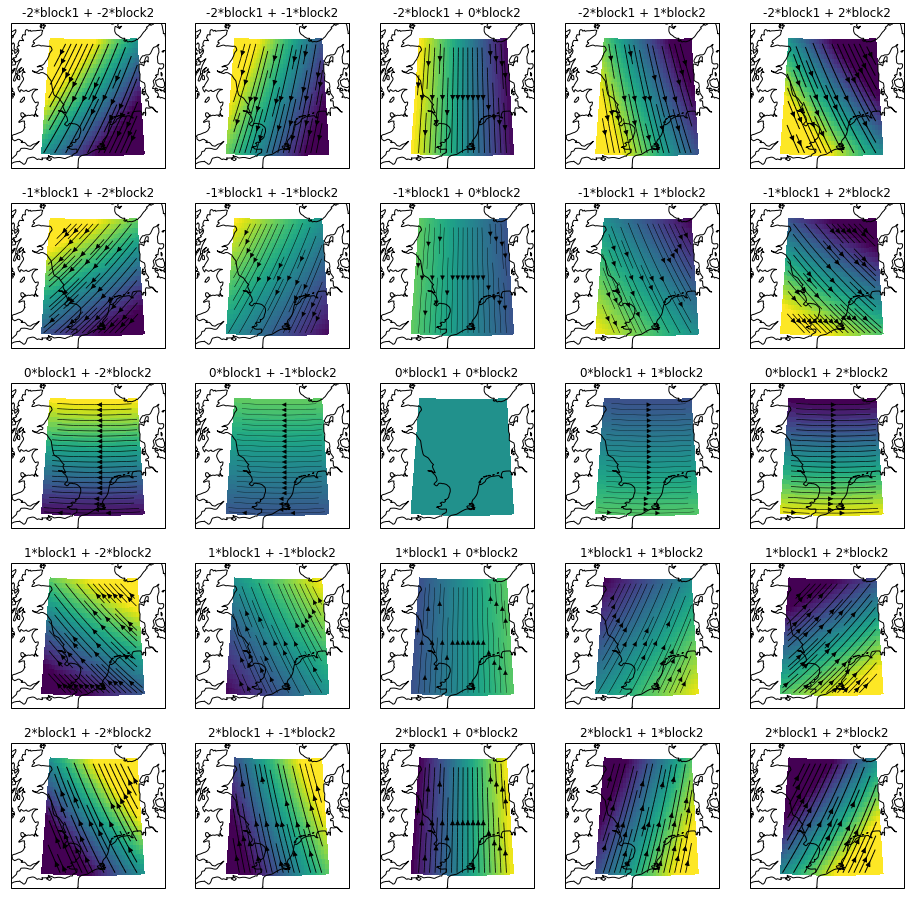

In [134]:
fig = plt.figure(figsize=(16,16))
count = 0
for i in range(5):
    for j in range(5):
        count += 1
        ax = nicemap(fig, pos=(5, 5, count))
        a, b = i-2, j-2 # weights of each block
        ax.pcolormesh(msl.longitude, msl.latitude, (a*block1+b*block2), transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
        
        ug, vg = geowind((a*block1+b*block2))
        speed = (ug**2+vg**2)**.5
        lw = speed / 0.065 # using equal scaling for each plot
        strp = ax.streamplot(msl.longitude, msl.latitude, ug, vg, color='k', linewidth=lw, transform=ccrs.PlateCarree())
        
        ax.set_title('%i*block1 + %i*block2'%(a,b))
        
plt.show()

Using different combinations of 2 building blocks, we have constructed 25 different pressure patterns, with 12 different wind directions. Notice how the flow is reversed if the building block is multiplied by a negative number, and how a stronger gradient leads to a stronger wind.

This idea is very powerful, as instead of storing 25 pressure fields consisting of 25\*35 points each, we can store the two building blocks along with 25\*2 weighting coefficients. We can also visualize these coefficients much more consicely than the full dataset - without losing any information:

Text(1,-2,'Strongish NNW')

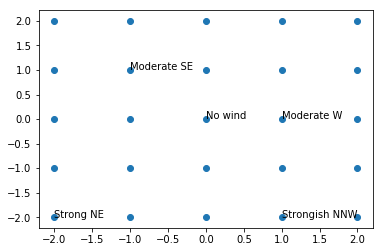

In [151]:
x,y = np.mgrid[-2:3,-2:3]
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.annotate('No wind', xy=(0, 0))
ax.annotate('Strong NE', xy=(-2, -2))
ax.annotate('Moderate W', xy=(1, 0))
ax.annotate('Moderate SE', xy=(-1, 1))
ax.annotate('Strongish NNW', xy=(1, -2))

## Better building blocks
Of course we cannot represent all possible pressure fields with these two simple building blocks. We are limited to uniform wind fields over our domain, for example. We might try to add some more building blocks, but what should they look like? This is where principal component analysis comes in. Given a set of pressure fields (or any other data), PCA is able to identify building blocks. Moreover, it will sort these building blocks by their relative importance. That means that the first building blocks will be able to reconstruct the bulk of the variation in our pressure fields, while the later building blocks will only add some subtle features. This is convenient, because it means that in order to identify dominant weather patterns, we will only need the first few building blocks. Let's see this in action.

We will use the scikit-learn package to apply the PCA. In sklearn/python language, PCA is an *object*, more specifically: a transformer object. This means we can use the pca-object to convert between 'real pressure fields' and 'buidling blocks with their associated weights'. 

In our example dataset, we had 720 pressure fields, let's call these *instances* or *samples*. Furthermore, we had 35 longitudes and 25 latitudes. The mean sea level pressure at each of these points is a *feature* or a *dimension* or a *variable*. In total, we have 35\*25 = 875 features. The pca-object does not understand our grid, and it will be confused if the features are 2-dimensional. Therefore, we will reshape our msl data, so that its shape will be (n_samples, n_features).

In [155]:
# In order to work with PCA, we need to reshape our data
print msl.shape
print msl.dims
ntime, nlat, nlon = msl.shape
msl_reshaped = msl.values.reshape(ntime,-1) # -1 means infer the remaining dimension
print msl_reshaped.shape

(720L, 25L, 35L)
(u'time', u'latitude', u'longitude')
(720L, 875L)


Now, let's instantiate our pca-object. This doesn't do much yet.

In [163]:
pca = PCA()

Now we will use this pca-object to transform our msl fields. This is done with PCA's `fit` method.

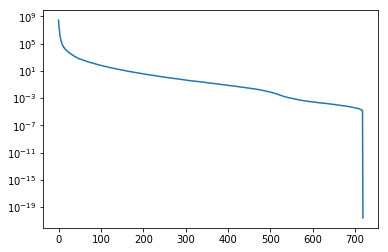

(720L, 875L)


In [172]:
pca.fit(msl_reshaped)
components = pca.components_
importance = pca.explained_variance_ 

fig, ax = plt.subplots()
ax.semilogy(importance)
plt.show()
print components.shape

The `fit` method has converted our pressure fields to components or buildings, which are stored in the its attribute `pca.components_`. I've printed the shape, so you can see that it is the same as our original data. However, now the shape is defined as (n_components, n_features). So, we have 720 components (building blocks), and each of them has 875 features (grid points). They are sorted by their relative importance. This importance is also stored in a attribute of the pca-object: `explained_variance_`. It can be seen that the explained variance is very high for the first few components, and drops rapidly for the later components.

Let's see what these components, or building blocks, look like.

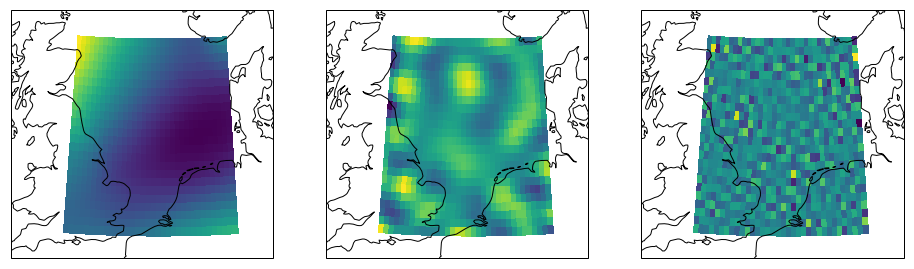

In [181]:
fig = plt.figure(figsize=(16,6))
ax1 = nicemap(fig, 131)
ax2 = nicemap(fig, 132)
ax3 = nicemap(fig, 133)

# Need to convert back to the original shape for plotting
ax1.pcolormesh(msl.longitude, msl.latitude, components[0].reshape(nlat, nlon), transform=ccrs.PlateCarree())
ax2.pcolormesh(msl.longitude, msl.latitude, components[50].reshape(nlat, nlon), transform=ccrs.PlateCarree())
ax3.pcolormesh(msl.longitude, msl.latitude, components[500].reshape(nlat, nlon), transform=ccrs.PlateCarree())

plt.show()

Notice how the first (principal) component has a clear large-scale structure, whereas the later components have a more fine-grained structure, up to a noisy pattern that contains little extra information in the last few components. That's why we are mainly interested in the first few components. During the initiation of the pca-object, we can define how many components we want to keep. Let's keep just the first three.

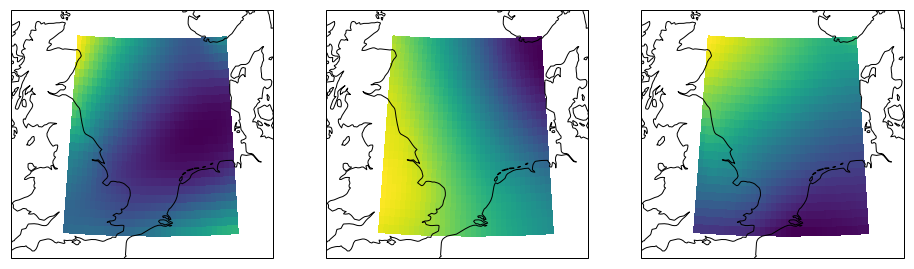

In [183]:
pca = PCA(n_components=3)
pca.fit(msl_reshaped)
components = pca.components_

fig = plt.figure(figsize=(16,6))
ax1 = nicemap(fig, 131)
ax2 = nicemap(fig, 132)
ax3 = nicemap(fig, 133)

# Need to convert back to the original shape for plotting
ax1.pcolormesh(msl.longitude, msl.latitude, components[0].reshape(nlat, nlon), transform=ccrs.PlateCarree())
ax2.pcolormesh(msl.longitude, msl.latitude, components[1].reshape(nlat, nlon), transform=ccrs.PlateCarree())
ax3.pcolormesh(msl.longitude, msl.latitude, components[2].reshape(nlat, nlon), transform=ccrs.PlateCarree())

plt.show()

Notice how similar these three components are to our initial building blocks! The second component defines a more or less linear NE-SW gradient, and the third component a SE-NW gradient. The first component has a more circular pattern, defining a low (or high, using negative weights) pressure center over the German Bight. 

##### Disclaimer
At this point, it is worthwhile to note that we are still only looking at June of 2010. The weather in this month was quite settled, so we cannot expect that these components are the best fit for the full range of circulation patterns that occur throughout the year.

Now that we have inspected the principle components, let's look at the weights. Remember that we need weights for each component, for each pressure field instance or sample. We can obtain these weights by using the PCA `transform` method.

In [185]:
weights = pca.transform(msl_reshaped)
weights.shape

(720L, 3L)

Indeed, we have 720 times, and since we decided to keep only the first three components, we have three weights per timestep. This is quite easy to visualize.

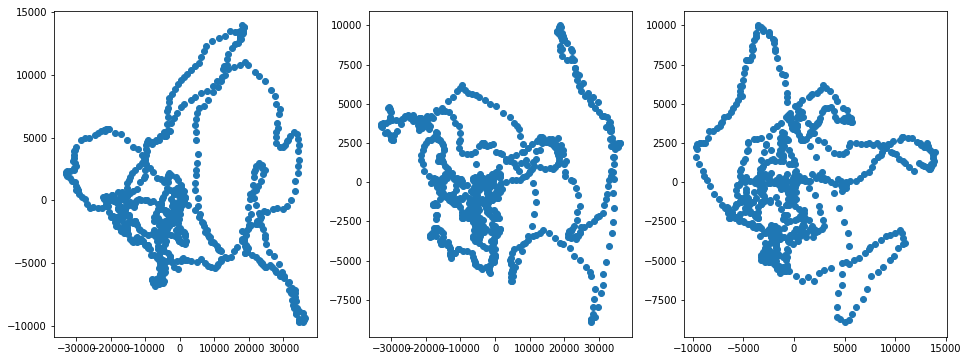

In [188]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
ax[0].scatter(weights[:,0], weights[:,1])
ax[1].scatter(weights[:,0], weights[:,2])
ax[2].scatter(weights[:,1], weights[:,2])
plt.show()

We can see that the weights all have quite large values. This is because the msl field was expressed in Pa, with typical values around 100 000. The components' values are typically small, so to reconstruct the msl field, we need large weights. We also see that there is a clear path in the above plots. This is because the msl during two consecutive hours is still quite similar, and hence the evolution of the pressure field in this month can still be traced. Interestingly, the further two consecutive points lay apart, the faster the msl pressure field evolves. 

Now what do these weights mean? We can try to interpret them as before. For example, we know that PC2 was representative of a northeasterly flow, and PC3 for a northwesterly flow. Similarly, PC1 is indicative of a more circular flow. Let's try to see what that implies.

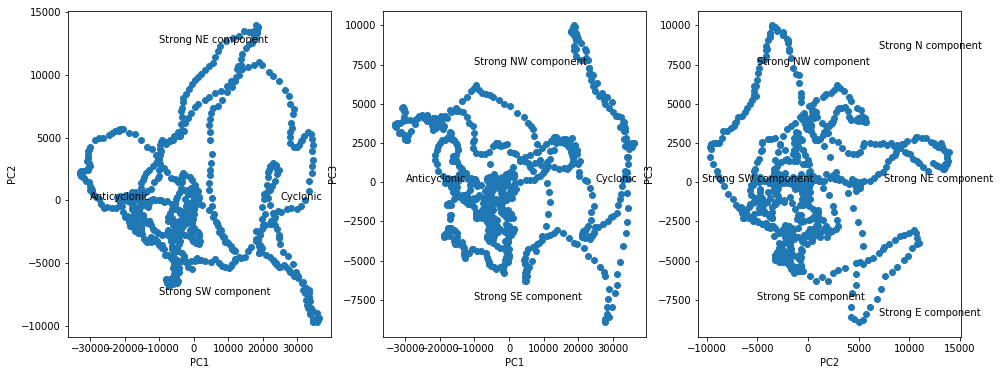

In [205]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
ax[0].scatter(weights[:,0], weights[:,1])
ax[1].scatter(weights[:,0], weights[:,2])
ax[2].scatter(weights[:,1], weights[:,2])

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')

ax[0].annotate('Cyclonic', (25000,0))
ax[0].annotate('Anticyclonic', (-30000,0))
ax[0].annotate('Strong NE component', (-10000,12500))
ax[0].annotate('Strong SW component', (-10000,-7500))

ax[1].annotate('Cyclonic', (25000,0))
ax[1].annotate('Anticyclonic', (-30000,0))
ax[1].annotate('Strong NW component', (-10000,7500))
ax[1].annotate('Strong SE component', (-10000,-7500))

ax[2].annotate('Strong NE component', (7500,0))
ax[2].annotate('Strong SW component', (-10500,0))
ax[2].annotate('Strong NW component', (-5000,7500))
ax[2].annotate('Strong SE component', (-5000,-7500))
ax[2].annotate('Strong E component', (7000,-8500))
ax[2].annotate('Strong N component', (7000,8500))

plt.show()

Of course, this is rather imprecise, and if we include more components it will be difficult to interpret these components physically. One of the components my relate to 'a slight dip in pressure over lake IJssel cooinciding with a positive pressure perturbation over London' and so on. Luckily, this is not necessary. 

## Grouping our samples in clusters
Now that we have reduced our dataset of 720\*25\*35 points to a set of 720\*3 weights, filtering out small-scale features of minor importance, we can try to group similar circulation patterns together. For this, we will use another function from the scikit-learn package, namely K-means.

Like PCA, KMeans is an object. But instead of transforming from sample to component space, KMeans assigns each sample to one of several clusters. These clusters are characterized by their cluster center. Let's first illustrate this using some random data. The sample data should have shape (n_samples, n_features)

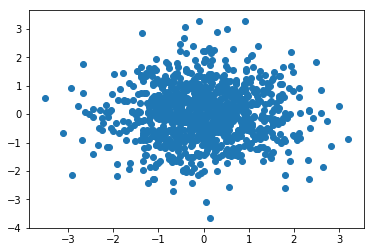

(1000L, 2L)


In [212]:
x = np.random.randn(1000,2)
fig, ax = plt.subplots()
ax.scatter(x[:,0],x[:,1])
plt.show()
print x.shape

In [218]:
kmeans = KMeans()
kmeans.fit(x)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
print centers.shape
print clusters.shape

(8L, 2L)
(1000L,)


After fitting the data, the kmeans object has 'learned' the cluster centers, and moreover, it has decided to which cluster each sample belongs. The shape of the cluster centers is (8,2). This means we have 8 clusters (which is the default) and each cluster center is defined by two points. We also have 1000 labels; one for each sample. Let's plot these cluster centers and color the points according to the labels.

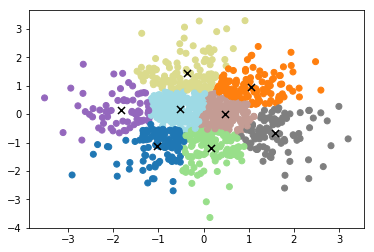

In [233]:
fig, ax = plt.subplots()
ax.scatter(x=x[:,0], y=x[:,1], c=labels, cmap='tab20')
ax.scatter(centers[:,0], centers[:,1], c='k', s=50, marker='x')

This algorithm can also deal with more than 2 dimensions - but that's just harder to visualize. 

Now, let's apply it to our msl data. We will use the weights of each sample as input for the clustering, for two reasons: we filter out small scale effects that are not relevant for the weather type, and the kmeans algorithm is (much) more efficient for 3 dimensions than for 825.

Text(0,0.5,'PC3')

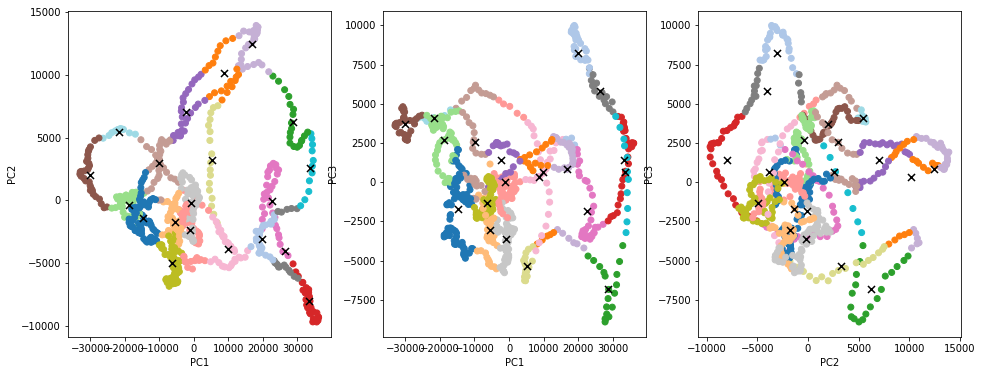

In [238]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(weights)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
fig, ax = plt.subplots(1,3, figsize=(16,6))
ax[0].scatter(weights[:,0], weights[:,1], c=labels, cmap='tab20')
ax[0].scatter(centers[:,0], centers[:,1], c='k', s=50, marker='x')
ax[1].scatter(weights[:,0], weights[:,2], c=labels, cmap='tab20')
ax[1].scatter(centers[:,0], centers[:,2], c='k', s=50, marker='x')
ax[2].scatter(weights[:,1], weights[:,2], c=labels, cmap='tab20')
ax[2].scatter(centers[:,1], centers[:,2], c='k', s=50, marker='x')

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')


Note that the cluster centers can be quite close together in two dimensions, but far apart in the third dimension.

Of course, this will make more sense when we include much more msl data. However, just as an example, I will use these clusters to select and analyse part of my msl data.

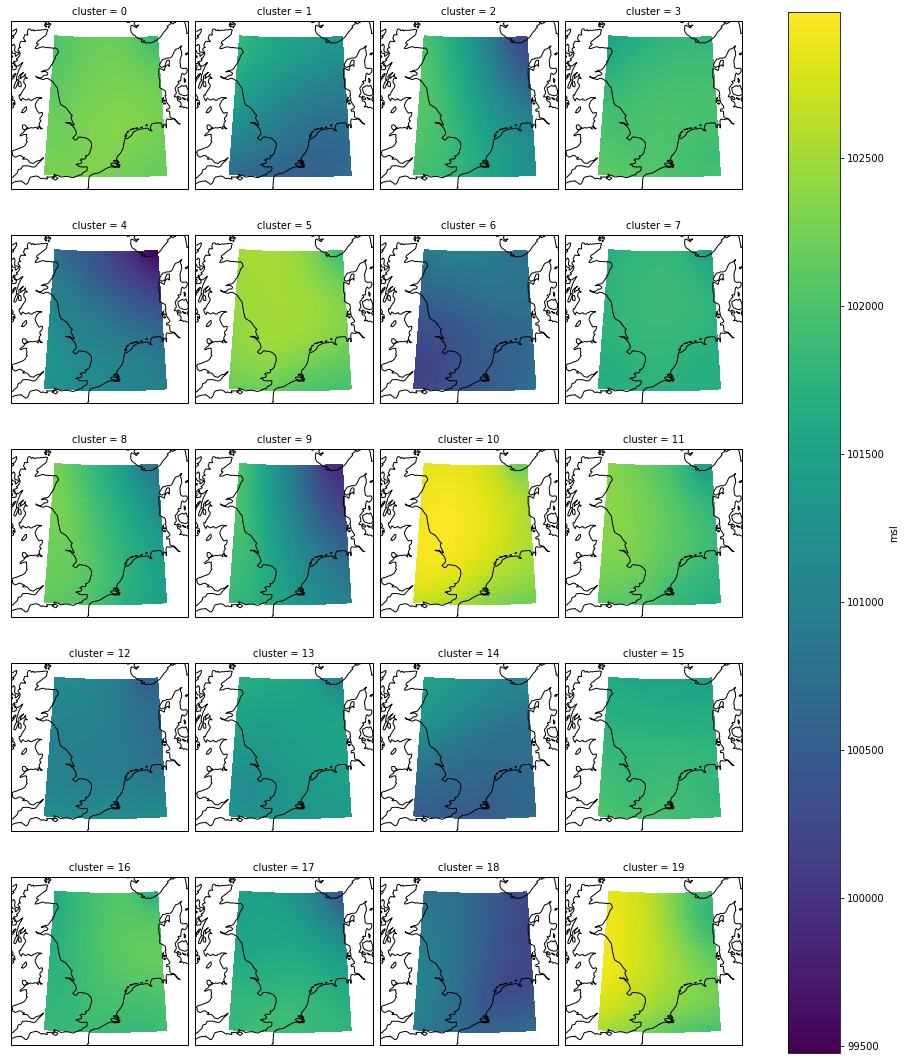

In [251]:
# Define the cartopy projection
clat,clon = 52.8481667, 3.4356667
proj = ccrs.LambertConformal(
    central_longitude=clon,
    central_latitude=clat,
    standard_parallels=(45,55),
    globe=ccrs.Globe(datum='WGS84',ellipse='sphere'))


# I will store the labels inside my msl variable:
msl['cluster'] = msl.time.copy() # copying is an easy way to duplicate shape and dimension information
msl.cluster.values = labels

# Calculate the mean sea level pressure for each cluster and plot it
means = msl.groupby('cluster').mean(dim='time')
fg = means.plot(col='cluster', col_wrap=4, transform=ccrs.PlateCarree(), 
                subplot_kws={'projection': proj, 'extent':[-5,10,50,59]})

for ax in fg.axes.flat:
    ax.coastlines('50m')
    
plt.show()

## Conclusion
In this notebook I've illustrated the basic ideas behind weather classification based on principal components of the mean sea level pressure field. PCA can be used to reduce a set of sea level pressure fields to a much more comprehensive set of 'weighting coefficients'. These weights can be combined with the principal components to describe the most essential features of the sea level pressure field. Subsequently, a clustering algorithm can be used to group these these weights into clusters with similar circulation patterns. Similar circulation patterns often bring similar weather, so this technique is very valuable for analysing meteorological datasets.

I used the scikit-learn package for both the principal component analysis. This package includes many other interesting functions, and it may be worthwhile to experiment with other clustering methods than kmeans.

In this example, I used only one month of sea level pressure data. Obviously, this does not give the most representative clusters that one can imagine. Thus, this notebook serves as an illustration of the methods, and not so much about the actual results.